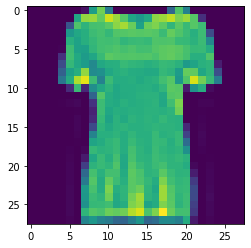

In [37]:
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torchvision
import torch.nn.functional as F
from tensorflow import keras
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from sklearn.model_selection import train_test_split


fashion_mnist = keras.datasets.fashion_mnist

# load dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
K = len(np.unique(train_labels))

X_train = np.reshape(train_images, (train_images.shape[0], train_images.shape[1]*train_images.shape[2]))
X_test = np.reshape(test_images, (test_images.shape[0], test_images.shape[1]*test_images.shape[2]))

Y_train = np.zeros((train_labels.shape[0], K))
Y_train[np.arange(Y_train.shape[0]), train_labels] = 1

Y_test = np.zeros((test_labels.shape[0], K))
Y_test[np.arange(Y_test.shape[0]), test_labels] = 1


X_test, X_validation, Y_test, Y_validation = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# train_data = fashion_mnist('../data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ]))
# 
# valid_data = fashion_mnist('../data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ]))
                   
# train_idx = np.random.choice(train_data.train_data.shape[0], 54000, replace=False)
# train_data.train_data = train_data.train_data[train_idx, :]
# train_data.train_labels = train_data.train_labels[torch.from_numpy(train_idx).type(torch.LongTensor)]
# mask = np.ones(60000)
# mask[train_idx] = 0
# valid_data.train_data = valid_data.train_data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
# valid_data.train_labels = valid_data.train_labels[torch.from_numpy(mask).type(torch.ByteTensor)]
# batch_size = 100
# test_batch_size = 100
# 
# train_loader = torch.utils.data.DataLoader(train_data,
#     batch_size=batch_size, shuffle=True)
# 
# valid_loader = torch.utils.data.DataLoader(valid_data,
#     batch_size=batch_size, shuffle=True)
# 
# test_loader = torch.utils.data.DataLoader(
#     fashion_mnist('../data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=test_batch_size, shuffle=True)
# plt.imshow(train_loader.dataset.train_data[1].numpy())
X_train = torch.tensor(X_train.T)
X_validation = torch.tensor(X_validation.T)
X_test = torch.tensor(X_test.T)

Y_train = torch.tensor(Y_train.T)
Y_validation = torch.tensor(Y_validation.T)
Y_test = torch.tensor(Y_test.T)

plt.imshow(train_images[10])
plt.show()
# 

In [38]:
class FcNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 10)

    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
# 
# 

In [39]:
def train(model, X, Y, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(zip(X, Y)):
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(X)  # calls the forward function
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return model


def valid(model, X, Y):
    model.eval()
    valid_loss = 0
    correct = 0
    for data, target in zip(X, Y):
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    valid_loss /= len(X)
    print('\n' + "valid" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(X),
        100. * correct / len(X)))
    return correct / len(X)


def test(model, X, Y):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in zip(X, Y):
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(X)
    print('\n' + "test" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(X),
        100. * correct / len(X)))


def experiment(model, epochs=10, lr=0.001):
    best_precision = 0
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        model = train(model, X_train, Y_train, optimizer)
        precision = valid(model, X_validation, Y_validation)

        if precision > best_precision:
            best_precision = precision
            best_model = model
    return best_model, best_precision

In [40]:
best_precision = 0
for model in [FcNetwork()]:  # add your models in the list
    # model.cuda()  # if you have access to a gpu
    model, precision = experiment(model)
    if precision > best_precision:
        best_precision = precision
        best_model = model

test(best_model, X_test, Y_test)

RuntimeError: Expected object of scalar type Float but got scalar type Byte for argument #2 'mat1' in call to _th_addmm